<center>
<h1>Mustererkennung und Machine Learning</h1>

<h3> Wintersemester 2017/2018, 5th Exercise Sheet</h3>
<h4>Konstantin Jaehne, Luis Herrmann; Dozent: Raúl Rojas</h4>

<hr style='height:1px'>
</center>

# Aufgabe 1

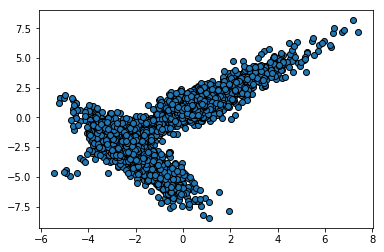

In [1]:
%matplotlib inline
import sys
import numpy as np
import cudamat as cm
import random as rd
import numpy.random as nprd
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

folderpath = '../'
filename = '2d-em.csv'
data = pd.read_csv(folderpath+filename, header=None).as_matrix()

plt.scatter(*zip(*data), edgecolors='black')

Our first implementation was quite straight-forward and naive.

In [2]:
def exmax(data, k, limit=30):
    #Select k random start values from the provided data, add noise:
    dim = len(data[0])
    mu = [data[i] for i in rd.sample(range(len(data)),k)]
    Sigma = [np.zeros(dim) for x in range(k)]
    Sigmai = [np.identity(dim) for x in range(k)]
    mapping = [-1]*len(data)
    change, count = True, 0
    while(change and count < limit):
        change = False
        points = [[] for i in range(k)]
        for i in range(len(data)):
            cluster = min(range(k), key=lambda j: np.dot(data[i]-mu[j], np.dot(Sigmai[j], data[i]-mu[j])))
            points[cluster].append(data[i])
            change = change or (mapping[i] != cluster)
            mapping[i] = cluster
        #print(','.join([str(len(x)) for x in points]))
        for i in range(k):
            if(len(points[i])>0):
                mu[i] = sum(points[i])/len(points[i])
        #mu = [sum(points[i])/len(points[i]) if len(points[i])>0 else mu[i] for i in range(k)]
        Sigmai = []
        for i in range(k):
            if(len(points[i]) > 0):
                Sigma[i] = np.cov(np.array(points[i]).transpose())
                try:
                    Sigmai.append(np.linalg.inv(Sigma[i]))
                except:
                    Sigmai.append(np.identity(dim))
            else:
                Sigmai.append(np.identity(dim))
        #Sigmai = [np.linalg.inv( for i in range(k)]
        count += 1
        sys.stdout.write(str(count) + ' iterations.\r')
    return(mu, Sigma)
        

However, we soon realized that it would be too slow to run the second exercise in a reasonable time. In order to make the implementation as efficient as possible, we used a couple of tweaks to dramatically increase performance:

<ol>
<li> For a given $\mu_k$, rather than computing $x-\mu_k$ for each vector $x$ from the data, we may as well do that for all vectors at the same time by ordering them as rows in matrix and applying row-wise subtraction. Doing this in one operation is considerably faster than iterating over the $x$ in a for-loop.</li>
<br>
<li>Following the same spirit, we can signficantly speed up the calculations of the respective Mahalanobis distances. For a data vector $x$ and a cluster mean vector $mu_k$, these are given by:<br>

<center>$d(x, \mu_k) = (x - \mu_k)^T\Sigma^{-1}(x - \mu_k)$</center><br>

Here, $x$, $\mu_k$ are both vectors. However, remember we already computer that difference by doing a row-wise operation on the data matrix. Now consider the following: When you multiply a matrix $A$ onto another matrix $B$ consisting of column vectors $b_1$, ... $b_n$, the resulting matrix product is the same as if we were applying $A$ onto each column vector indivdually, that is: $A (b_1,...,b_n) = (Ab_1, ... , Ab_n)$.

Thus, rather than calculating the Mahalanobis distances for each pair of $x$, $\mu_k$, for a given $\mu_k$ we can calculate the distance for all data vectors in one go simply by applying the inverse covariance matrix $\Sigma$ onto the difference matrix obtained in the first step.<br><br>

However, since the result of that operation is not a vector anymore, but a matrix, we cannot simply proceed to apply np.dot on $x-\mu$ and the resulting $\Sigma^{-1}(x-\mu_k)$, for the resulting matrix would not be a vector containing all norms. Instead, iterating over $i$, we want to take the rows $x_i$ and $(\Sigma^{-1}(x-\mu_k))_i$ (Note that we are now treating $x$ as a matrix), multiply the respetive elements and add them up. This can be done in a go using the numpy functions np.multiply and np.sum.<br>
As a result, we get a vector that has as many entries as data sets an contains the respective distances $d(x_i, \mu_k)$, which we abbreivate $d(x_i, \mu_k)$. Now, using the function np.argmin, we can obtain a row vector, where each entry contains the column index for which the entries in that row are minimal.
</li>
<br>
<li>
Now, there is one important optimization remaining, namely the extraction of the minimal distances for each vector. Turns out this can also be done in a go. Iterating over all clusters $k$, we obtain all distance vectors, which can then be stacked to a matrix $(d(x_i, \mu_1),..., d(x_i, \mu_{k_{\max}}))$
</li>

</ol>




<p>As a final improvement, we implemented the same using the methods of the <b>cudamat</b> library (https://github.com/cudamat/cudamat), which is a Python library for performing array-type operations on the CUDA-GPUs, prodiving a syntax similar to that of numpy. Since we ran the code on a Windows computer, we will briefly comment on how we got cudamat to run on Windows. Cudamat requires the Nvidia CUDA Toolkit (https://developer.nvidia.com/cuda-toolkit) to be installed, so our first step was to download and install said toolkit.
In theory, one could now proceed to run pip install . in the cloned cudamat folder. However, we ran into issues when trying to compile the cudamat code in this way. Instead, we had to manually compile the two required DLLs using the nvcc.exe (NVDIA CUDA Compiler), which in turn requires cl.exe (C++-C-Compiler for Windows) to be installed (and detectable in the PATH). The compilation was done using the commands:</p>

<p style='font-family: Consolas'>
nvcc -c -O -o cudamat.obj cudamat.cu<br>
nvcc -c -O -o cudamat_kernels.obj cudamat_kernels.cu<br>
nvcc --shared -o libcudamat.dll cudamat.obj cudamat_kernels.obj -lcublas<br>
nvcc -c -O -o learn.obj learn.cu<br>
nvcc -c -O -o learn_kernels.obj learn_kernels.cu<br>
nvcc --shared -o libcudalearn.dll learn.obj learn_kernels.obj -lcublas<br>
</p>

Finally, this allows us to comfortably import cudamat using 'import cudamat'.

In [3]:
def exmax_(data, k, limit=30, gpu=False, reti=False, kmeanspp=True, mu=None):
    """
    Expects the following parameters:
        data:
            Type: Array-type (matrix)
            A matrix in which each row contains a feature vector
        k:
            Type: Integer
            Number of clusters
        limit (optional):
            Type: Integer
            Number of iterations after which the function will stop executing
        gpu (optional):
            Type: Boolean
            Specifies whether code will run on gpu using cudamat
        reti (optioanl):
            Type: Boolean
            If true, function, will return a list of length k containing the indices of row feature vectors of data
            assigend to the i-th cluster in the list.
        kmeanspp (optional):
            Type: Boolean
            By default true, determines to use the improved algorithm for the selection of k random initial mean vectors.
            If false, the algorithm will instead select the mean vectors completely at random.
        mu (optional):
            Type: Array-like (vector)
            Allows initial guess of mean vectors. If mu is provided, k will be set to length of mu.
    """
    dim = data.shape[1]
    samplesize = data.shape[0]
    #If standard memory exceeded, allocate more space:
    if(gpu):
        if(data.shape[0] > 256*1024):
            cm.init(data.shape[0])
        else:
            cm.init()
    
    #Select initial mu:
    if(mu is None and kmeanspp == True):
        #Improved initial selection:
        sys.stdout.write('Selecting start points...')
        mu_pos = []
        #At first iteration, all vectors equally likely to be chosen
        probs = np.repeat(1/data.shape[0], data.shape[0])
        for i in range(k):
            mu_pos.append(np.random.choice(data.shape[0], 1, p=probs)[0])
            x = data - data[mu_pos[i]]
            distances = np.sum(np.multiply(x,x), axis=1)
            #Convert to weighted probability vector:
            probs = distances/np.sum(distances, axis=0)
            #Set probabilites for all vectors already selected to zero
            probs[mu_pos] = 0
            probs /= sum(probs)
        mu = data[mu_pos]
        sys.stdout.write('Done!\n')
    elif(mu is None and kmeanspp == False):
        mu = data[rd.sample(range(len(data)),k)]
    else:
        k = len(mu)
        
    Sigma = [np.zeros(dim) for x in range(k)]
    Sigmai = [np.identity(dim) for x in range(k)]
    clusters = np.repeat(-1, k)
    count = 0
    indexlist = [np.empty(0) for i in range(k)]
    while(count < limit):
        distances = []
        clusters_ = None
        if(gpu):
            for i in range(k):
                x_gpu = cm.CUDAMatrix(data)
                mu_gpu = cm.CUDAMatrix(mu[i].reshape(1,dim))
                mu_gpu.mult(-1)
                x_gpu.add_row_vec(mu_gpu)
                Sigma_gpu = cm.CUDAMatrix(Sigmai[i])
                x_gpu_ = cm.dot(x_gpu, Sigma_gpu)
                x_gpu.mult(x_gpu_)
                x_gpu_sum = x_gpu.sum(axis = 1)
                res = x_gpu_sum.asarray()
                del x_gpu, mu_gpu, Sigma_gpu, x_gpu_, x_gpu_sum
                distances.append(res)
                
            clusters_ = np.argmin(np.column_stack(distances), axis=1)
            if(np.array_equal(clusters, clusters_)):
                break;
            else:
                clusters = clusters_
                for i in range(k):
                    indices = np.where(clusters == i)[0]
                    if(reti):
                        indexlist[i] = indices
                    if(len(indices) != 0):
                        vectors_i = np.take(data, indices , axis=0)
                        vectors_i_gpu = cm.CUDAMatrix(vectors_i)
                        mean = vectors_i_gpu.mean(axis=0)
                        mu[i] = np.reshape(mean.asarray(), dim)
                        mean.mult(-1)
                        vectors_i_gpu.add_row_vec(mean)
                        cov = cm.dot(vectors_i_gpu.T, vectors_i_gpu)
                        cov.divide(vectors_i_gpu.shape[0])
                        Sigma[i] = cov.asarray()
                        del vectors_i_gpu, mean, cov
                        try:
                            Sigmai[i] = np.linalg.inv(Sigma[i])
                        except:
                            pass
        else:
            for i in range(k):
                x = data - mu[i]
                distances.append(np.sum(np.multiply(np.dot(x, Sigmai[i]), x), axis=1))
            clusters_ = np.argmin(np.column_stack(distances), axis=1)
            if(np.array_equal(clusters, clusters_)):
                break;
            else:
                clusters = clusters_
                for i in range(k):
                    indices = np.where(clusters == i)[0]
                    if(reti):
                        indexlist[i] = indices
                    if(len(indices) != 0):
                        vectors_i = np.take(data, indices , axis=0)
                        mu[i] = np.sum(vectors_i, axis=0)/vectors_i.shape[0]
                        Sigma[i] = np.cov(np.transpose(vectors_i))
                        try:
                            Sigmai[i] = np.linalg.inv(Sigma[i])
                        except:
                            pass
        count += 1
        sys.stdout.write(str(count) + ' iterations.\r')
    if(gpu):
        cm.shutdown()
    sys.stdout.write('\n')
    if(reti):
        return(mu, Sigma, indexlist)
    else:
        return(mu, Sigma)

In [4]:
def plot1(mu, Sigma, k, indexl):
    colors = plt.get_cmap('coolwarm')
    #colors = plt.cm.plasma(np.linspace(0,1,k))
    norm = mpl.colors.Normalize(vmin=0.0, vmax=float(k))

    arcs = np.linspace(0, 2 * np.pi, 100)
    xy = [[np.sin(x), np.cos(x)] for x in arcs]
    for i in range(k):
        if(len(indexl[i]) > 0):
            xydata = np.dot(Sigma[i], np.transpose(np.array(xy))) + mu[i].reshape(2,1)
            plt.scatter(*zip(*data[indexl[i]]), color=colors(norm(i)), edgecolors='black')
            plt.plot(*xydata, color='yellow')
            plt.scatter(*zip(*mu), s=100, color='yellow', edgecolors='black')
    plt.show()

We run the computations without GPU support, as this turned out to be faster for data sets of this relatively small size. The cause for this is probably the fact that in order to perform the computations on the GPU, the data will have to be loaded onto the latter. This takes additional time, such that doing the computations on the GPU will only lead to a speedup over CPU computation for larger data sets (such as in exercise 2).

Selecting start points...Done!
1 iterations.
Wall time: 1.67 s
Cluster sizes: 3000


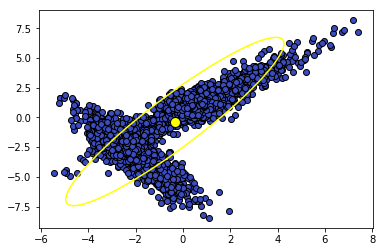

Selecting start points...Done!
10 iterations.
Wall time: 957 ms
Cluster sizes: 1885, 1115


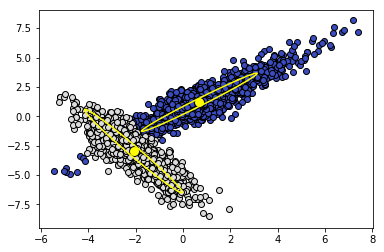

Selecting start points...Done!
11 iterations.
Wall time: 977 ms
Cluster sizes: 32, 1116, 1852


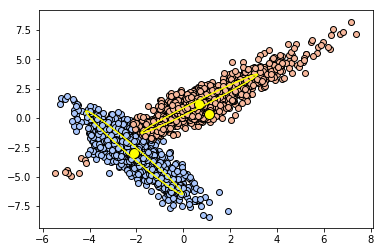

Selecting start points...Done!
21 iterations.
Wall time: 1.27 s
Cluster sizes: 1727, 833, 128, 312


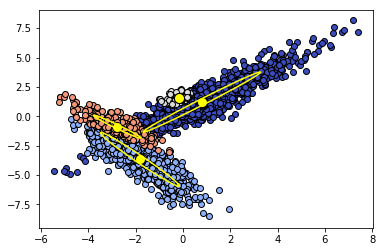

Selecting start points...Done!
28 iterations.
Wall time: 1.56 s
Cluster sizes: 739, 1, 1809, 399, 52


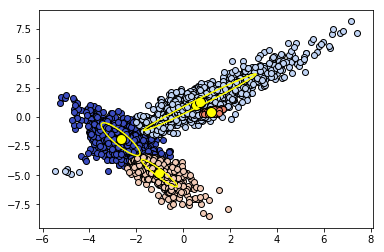

Selecting start points...Done!
33 iterations.
Wall time: 1.82 s
Cluster sizes: 402, 1798, 1, 730, 66, 3
Selecting start points...Done!
51 iterations.
Wall time: 2.7 s
Cluster sizes: 579, 4, 4, 3, 533, 1, 1876
Selecting start points...Done!
33 iterations.
Wall time: 2.14 s
Cluster sizes: 341, 13, 3, 12, 1809, 14, 565, 243
Selecting start points...Done!
32 iterations.
Wall time: 2.19 s
Cluster sizes: 583, 1, 0, 0, 1, 1879, 0, 536, 0


<Container object of 9 artists>

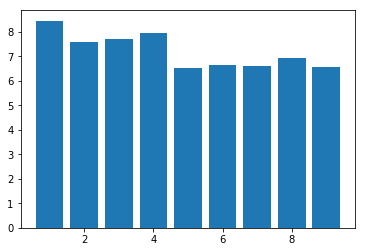

In [5]:
quality = []
test = []
plotselection = range(1,6)
for k in range(1, 10):
    %time mu, Sigma, indexl = exmax_(data, k, 100, gpu=True, reti=True)
    quality.append(sum([np.linalg.norm(Sigma[i]) for i in range(k)]))
    print('Cluster sizes: ' +  ', '.join([str(len(x)) for x in indexl]))
    if(k in plotselection):
        plot1(mu, Sigma, k, indexl)

plt.bar(range(1,10), quality, align='center')


# Aufgabe2

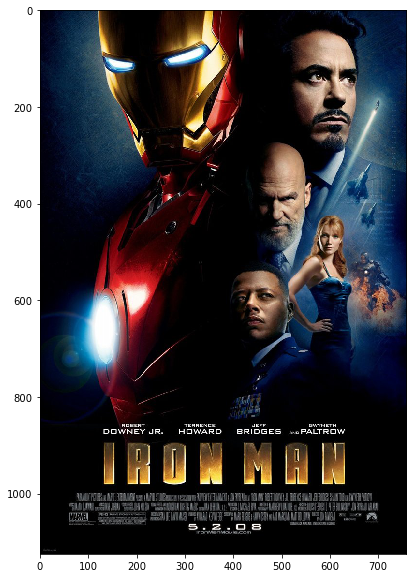

In [6]:
folderpath2 = '../'
filename2 = 'rsz_iron_man.jpg'
from PIL import Image
img = Image.open(folderpath2 + filename2)
arr = np.array(img)

mpl.rcParams['figure.figsize'] = (10,10)
plt.imshow(arr)
data2 = arr.copy().astype(float)
data2 = np.reshape(data2,[data2.shape[0]*data2.shape[1],data2.shape[2]])

In [7]:
import itertools as it

For this particular problem, we have several options: One is to select random initial means as we did in the previous problem and then run expectation-maximization. Or we can conveniently guess a number of initial mean vectors (colors), for example by subdividing the RGB color space.

In [8]:
rgbrange = range(0,255,255//3)
mu_init = list(np.array(list(it.product(rgbrange,rgbrange,rgbrange)), dtype=np.float))

In [9]:
def plot2(indexl):
    data2_mod = data2.copy()
    mu_rd = np.round(np.row_stack(mu)).astype(np.uint8)
    for i in range(len(indexl)):
        if(len(indexl[i]) > 0):
            data2_mod[indexl[i]] = mu_rd[i]
    data2_mod = np.reshape(data2_mod, arr.shape)
    data2_mod.shape
    plt.imshow(data2_mod.astype(np.uint8))

The algorithm runs quickest when the initial points are selected completely at random:

4 iterations.
Wall time: 8.22 s


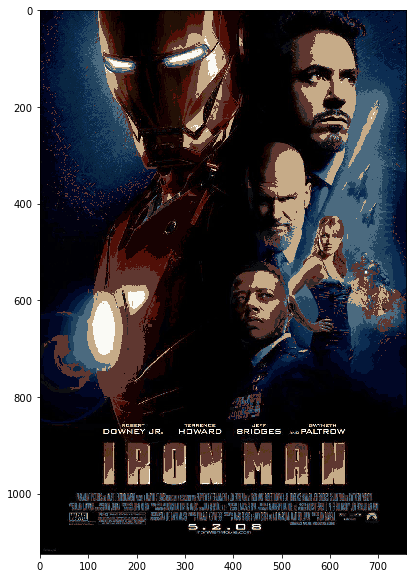

In [14]:
%time mu, Sigma, indexl = exmax_(data2.copy(), 25,4, kmeanspp=False, gpu=True, reti=True)#, mu=mu_init.copy())
plot2(indexl)

When we used improved initial selection, the algorithm takes longer to run as the selection of the starting points take a while. However, the results are typically more stable and also more convincing.

Selecting start points...Done!
4 iterations.
Wall time: 18.5 s


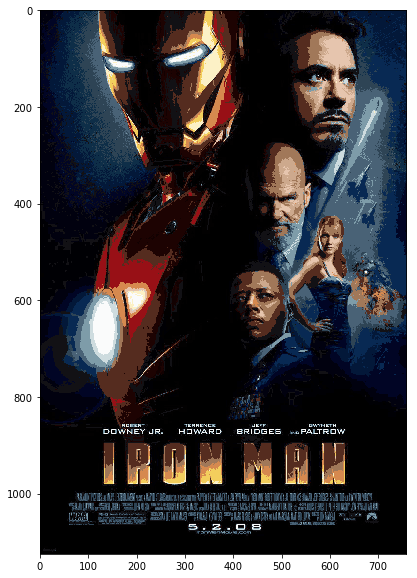

In [11]:
%time mu, Sigma, indexl = exmax_(data2.copy(), 25,4, kmeanspp=True, gpu=True, reti=True)#, mu=mu_init.copy())
plot2(indexl)

In contrast for a preselected vector mu:

5 iterations.
Wall time: 10.8 s


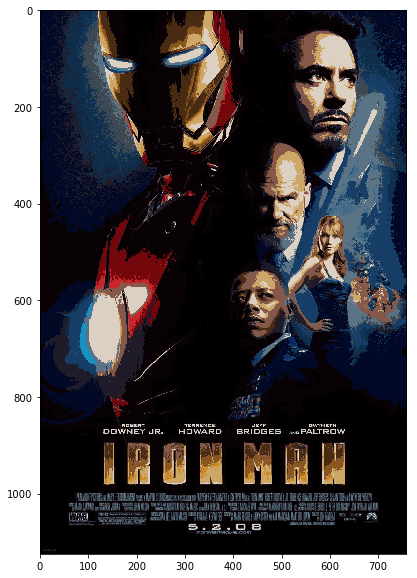

In [12]:
%time mu, Sigma, indexl = exmax_(data2.copy(), 25,5, gpu=True, reti=True, mu=mu_init.copy())
plot2(indexl)

Also note that the speedup thanks to GPU computation is significant compared to pure CPU computation:

5 iterations.
Wall time: 27.9 s


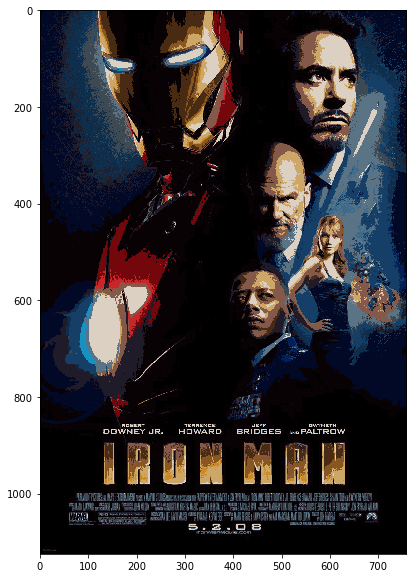

In [13]:
%time mu, Sigma, indexl = exmax_(data2.copy(), 25,5, gpu=False, reti=True, mu=mu_init.copy())
plot2(indexl)